In [1]:
%matplotlib inline

In [15]:
import sys
import os
import numpy as np
import matplotlib as mpl
import pickle as pk
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import shutil
import time
from IPython.display import clear_output
from time import sleep

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    
from flopy.utils.util_array import read1d
mpl.rcParams['figure.figsize'] = (8, 8)

exe_name_mf = '/Users/zitongzhou/Downloads/pymake/examples/mf2005'
exe_name_mt = '/Users/zitongzhou/Downloads/pymake/examples/mt3dms'
datadir = os.path.join('..', 'mt3d_test', 'mt3dms')
workdir = os.path.join('.',)
    
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))


class mymf:
    """
    modflow model for multiple well pumping
    every values are represented as 2D np array
    """
    def __init__(self, dirname='random'):
        self.dirname = dirname
        self.model_ws = os.path.join(workdir, self.dirname)
        
    def run_model(self, hk, welspd, c_spd):
        if os.path.isdir(self.dirname):
            shutil.rmtree(self.dirname, ignore_errors=True)

        Lx = 2500.  #meter
        Ly = 1250.
        nlay = 6
        nrow = 41
        ncol = 81
        ztop = 0.
        zbot = -50*nlay
        delr = Lx / (ncol-1)  # spacings along a row, can be an array
        delc = Ly / (nrow-1)  # spacings along a column, can be an array
    #        delv = (ztop - zbot) / nlay
        delv = 50
        prsity = 0.3

#         q0 = 100. #water injection
        q0 = 0.   #no injection
        c0 = 10000. #M/T, kg/

        perlen_mf = [365*4]*5 + [365*4]*5 #day
        perlen_mt = [365*4]*5 + [365*4]*5
    #     nper = len(perlen_mf)
        laytyp = 0. 
        rhob = 1.587 #bulk density of porous media g/m^3

        modelname_mf = self.dirname + '_mf'
        mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws= self.model_ws, exe_name=exe_name_mf)
        dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                       delr=delr, delc=delc, top=ztop, 
                                       botm=[-delv * k for k in range(1, nlay + 1)],
                                       nper=len(perlen_mf), perlen=perlen_mf)
        # Variables for the BAS package
        # active > 0, inactive = 0, or constant head < 0
        ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
        ibound[:, :, 0] = -1
        ibound[:, :, -1] = -1

        # initial head value also serves as boundary conditions
        strt = np.zeros((nlay, nrow, ncol), dtype=np.float32)
        h_grad = 0.012
        l_head, r_head = h_grad*Lx, 0.
        strt[:, :, 0] = l_head
        strt[:, :, -1] = r_head
        # hk = np.dstack((hk,hk))
        # hk = np.dstack((hk,hk))
        # hk = np.swapaxes(hk, 0, 2)
        # hk = np.swapaxes(hk, 1, 2)
        bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
        lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
        pcg = flopy.modflow.ModflowPcg(mf)
        lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')

        wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)

    #     spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
        spd = {(0, 0): ['save head', 'save budget']}
    #     oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
        oc = flopy.modflow.ModflowOc(mf,compact=True)
        mf.write_input()
        mf.run_model(silent = True)

        modelname_mt = self.dirname + '_mt'
        mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=self.model_ws, 
                               exe_name=exe_name_mt, modflowmodel=mf, ftlfilename='mt3d_link.ftl')

        self.obs =   [[4, 31, 49],
                     [4, 18, 56],
                     [4, 20, 48],
                     [4, 27, 76],
                     [4, 24, 60],
                     [4, 12, 31],
                     [4, 19, 69],
                     [4, 30, 32],
                     [4, 33, 38],
                     [4, 18, 65],
                     [4, 22, 74],
                     [4, 21, 38],
                     [4, 34, 55],
                     [4, 17, 44],
                     [4, 5, 66],
                     [4, 30, 59],
                     [4, 8, 52],
                     [4, 21, 60],
                     [4, 11, 40],
                     [4, 31, 40]]
        btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, 
#                                  ncomp=2, mcomp=2,
                                 prsity=prsity, sconc=0., 
#                                  sconc2=0., 
#                                  species_names=['TCE', 'PCE'],
                                 nper=len(perlen_mt), perlen=perlen_mt, nprs = -1, obs=self.obs)
        dceps = 1.e-9 # small Relative Cell Concentration Gradient below which advective transport is considered
        nplane = 1 #whether the random or fixed pattern is selected for initial placement of moving particles. If NPLANE = 0, the random pattern is selected for initial placement.
        npl = 0 #number of initial particles per cell to be placed at cells where the Relative Cell Concentration Gradient is less than or equal to DCEPS.
        nph = 16 #number of initial particles per cell to be placed at cells where the Relative Cell Concentration Gradient is greater than DCEPS. 
        npmin = 2
        npmax = 32
        nlsink = nplane #for sink cells
        npsink = nph
        mixelm = 0 # algorithm, -1: the third-order TVD scheme (ULTIMATE)
        adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                                 npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                                 nlsink=nlsink, npsink=npsink, percel=0.5)

        al = 35. #meter
        trpt = 0.3
        trpv = 0.3
        #dmcoef: molecular diffusion, m2/d

        dsp = flopy.mt3d.Mt3dDsp(
            mt, al=al, trpt=trpt, trpv=trpv, 
            dmcoef=1.e-9, 
#             dmcoef2=1.e-5 
        )
        lambda1 = 0.
        rct = flopy.mt3d.Mt3dRct(
            mt, isothm=2, ireact=0, igetsc=0, rhob=rhob, 
            sp1=0.1, sp2=0.9, 
#             sp12=0.23, sp22=0.9
        )


        ssm = flopy.mt3d.Mt3dSsm(mt, mxss=1500, stress_period_data=c_spd) #mxss: maximum number of all point sinks and sources
        gcg = flopy.mt3d.Mt3dGcg(mt)
        # write mt3dms input
        while True:
            try:
                mt.write_input()
            except OSError as err:
                print("mt File writing error: %s" % (err))
            else:  # if we succeed, get out of the loop
                break

        fname = os.path.join(self.model_ws, 'MT3D001.UCN')
        if os.path.isfile(fname):
            os.remove(fname)
#         fname2 = os.path.join(self.model_ws, 'MT3D002.UCN')
#         if os.path.isfile(fname2):
#             os.remove(fname2)
        mt.run_model(silent=True)

    #     fname = os.path.join(model_ws, 'MT3D001.UCN')
    #     ucnobj = flopy.utils.UcnFile(fname)
    #     times = ucnobj.get_times()
    #     conc = ucnobj.get_alldata()

        fname = os.path.join(self.model_ws, 'MT3D001.OBS')
        if os.path.isfile(fname):
            cvt1 = mt.load_obs(fname)
        else:
            cvt1 = None
        
        cvt2 = None
#         fname2 = os.path.join(self.model_ws, 'MT3D002.OBS')
#         if os.path.isfile(fname2):
#             cvt2 = mt.load_obs(fname2)
#         else:
#             cvt2 = None
        return cvt1, cvt2 
    
    def simple_plot(self, c_map, title=''):
        nx = 81
        ny = 41
        Lx = 2500
        Ly = 1250

        x = np.linspace(0, Lx, nx)
        y = np.linspace(0, Ly, ny)
        X,Y = np.meshgrid(x, y)
        fig, axs = plt.subplots(1,1)
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
        axs.set_xlim(0,Lx)
        axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
        name = title + '.pdf'
        plt.title(title)
#         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
        plt.show()
        return
    
    
    def head(self):
        hds = bf.HeadFile(os.path.join(self.model_ws, self.dirname + '_mf.hds'))
        times = hds.get_times()  # simulation time, steady state
        heads = hds.get_data(totim=times[-1])
        hds.close()  # close the file object for the next run

        head = heads[0]
        head = np.flip(head, 0)
        self.simple_plot(head, 'head')
        
    
    def take_obs(self, cvt):

        obss = [[self.obs[i][j]+1 for j in range(3)] for i in range(len(self.obs))]
        year = np.arange(2*365, 21*365, 2*365).tolist() + np.arange(20.5*365, 40*365+1, 365/2).tolist()
        def closest(lst, K): 
            lst = np.asarray(lst) 
            idx = (np.abs(lst - K)).argmin() 
            return idx
        inds = [closest(cvt['time'], year[i]) for i in range(len(year))]
        meas = [cvt[str(tuple(obss[i]))][inds] for i in range(len(obss))]
        return meas
    
    def make_movie(self, species='1'):
        fname = os.path.join(self.model_ws, 'MT3D00'+species+'.UCN')
        ucnobj = flopy.utils.UcnFile(fname)
        times = ucnobj.get_times()

        year = np.arange(2, 41)*365

        def close(lst, K): 
            lst = np.asarray(lst) 
            idx = (np.abs(lst - K)).argmin() 
            return lst[idx]

        time = [close(times, year[i]) for i in range(len(year))]
        nx = 81
        ny = 41
        Lx = 2500
        Ly = 1250

        x = np.linspace(0, Lx, nx)
        y = np.linspace(0, Ly, ny)
        X,Y = np.meshgrid(x, y)

        fig, axs = plt.subplots()
        #        axs.set_xlabel('x(m)')
        #        axs.set_ylabel('y(m)')
        axs.set_xlim(0,Lx)
        axs.set_ylim(0,Ly)

        for i in range(len(year)):
            c_map = ucnobj.get_data(totim=time[i])[0,]
            c01_map = plt.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
            plt.colorbar(c01_map, ax=axs, shrink=0.62)
            plt.title("year {}".format(i))
            plt.show()
            # Note that using time.sleep does *not* work here!
            sleep(0.1)
            if i < len(year)-1:
                clear_output(wait=True)
    
    def figures(self, species='1'):
        fname = os.path.join(self.model_ws, 'MT3D00'+species+'.UCN')
        ucnobj = flopy.utils.UcnFile(fname)
        times = ucnobj.get_times()
        year = np.arange(2*365, 21*365, 2*365).tolist() + np.arange(20.5*365, 40*365+1, 365/2).tolist()
        
        def close(lst, K): 
            lst = np.asarray(lst) 
            idx = (np.abs(lst - K)).argmin() 
            return lst[idx]

        time = [close(times, year[i]) for i in range(len(year))]
        maps = []
        for i in range(len(time)):
            maps.append(ucnobj.get_data(totim=time[i])[0,])
        return maps
        
if __name__ == '__main__':
    start = time.time()
    my_model = mymf('afolder')

    welspd = {}
    for i in range(5):
        welspd[i] = [3, 15, 25, 0.]
    welspd[5] = [3,15, 25, 0.]

    spd = {}
    for i in range(5):
        spd[i] = [
            (3, 15, 25, 1000., -1)
#             100000., 200000.),
            ]
    spd[5] = [
        (3, 15, 25, 0., -1,)
#         0., 0.)
        ]

    with open('3dkd.pkl', 'rb') as file:
        hk = np.exp(pk.load(file))

    cvt1, cvt2 = my_model.run_model(hk, welspd, spd)
    my_model.head()
    meas = my_model.take_obs(cvt1)
#     meas2 =  my_model.take_obs(cvt2)
    print(time.time() - start)
#     maps = my_model.figures()
#     my_model.make_movie()
#     maps2 = my_model.figures(species='2')
#     my_model.make_movie(species='2')
#     my_model.simple_plot(maps[1],'')

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy version: 1.19.2
matplotlib version: 3.3.1
flopy version: 3.3.2


KeyboardInterrupt: 

In [9]:
os.getcwd()

'/Users/zitongzhou/Desktop/react_inverse/TCP_3d'

timesteps:  4180


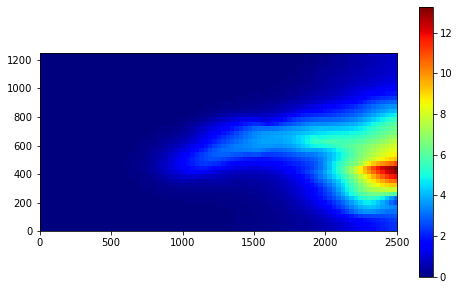

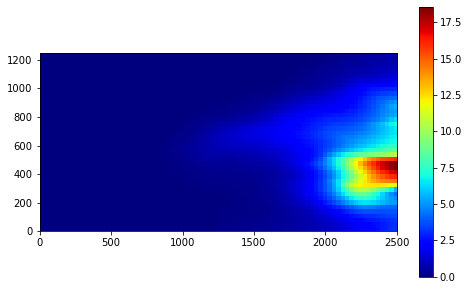

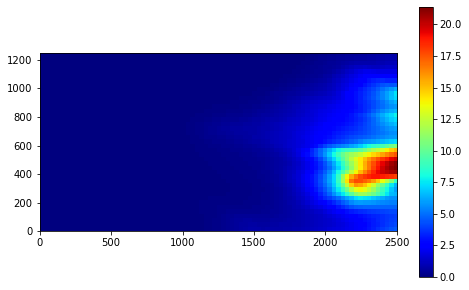

In [56]:
fname = os.path.join(my_model.model_ws, 'MT3D00'+'1'+'.UCN')
ucnobj = flopy.utils.UcnFile(fname)
times = ucnobj.get_times() # simulation time
print('timesteps: ', len(times))
#times1 = times[round(len(times)/5.)-1] # 1/5 simulation time
#times2 = times[round(len(times)/2.)-1] # 1/2 simulation time
mytime = times[-1] # the last simulation time
conc = ucnobj.get_data(totim=mytime)
my_model.simple_plot(conc[1],'')
my_model.simple_plot(conc[3],'')
my_model.simple_plot(conc[5],'')

In [4]:
with open('3dkd.pkl', 'rb') as file:
    hk = np.exp(pk.load(file))

In [5]:
hk

array([[[  3.92883325,   2.27720599,   2.3232754 , ...,   5.24158011,
           5.56463698,   3.47938394],
        [  3.24061135,   3.41830991,   2.30281376, ...,   5.37214221,
           3.84294308,   2.97840225],
        [  5.32130727,   3.99877074,   2.81450598, ...,   2.57268924,
           2.81259628,   4.30370918],
        ...,
        [  1.96613857,   1.53007576,   1.66916333, ...,   2.01853904,
           2.0309715 ,   2.37279361],
        [  1.57342379,   2.25810169,   1.53860629, ...,   2.51437874,
           2.16998065,   1.66376025],
        [  1.84729656,   1.53966714,   2.60977693, ...,   2.03643199,
           2.18238977,   2.88575265]],

       [[  3.88866826,   3.52881457,   3.39077158, ...,   3.8988017 ,
           2.78059379,   0.8110748 ],
        [  5.11496215,   4.34704911,   4.88897417, ...,   9.06426491,
           5.32202968,   5.39713631],
        [  9.67569915,   6.35003453,   2.82840656, ...,  15.3403828 ,
           4.93007771,   2.5691645 ],
        ...,
